# Model

The ultimate goal of the model is to learn a __latent variable space of musical units__. Then, given a musical unit, we wish to encode that unit into a latent vector within the space, and predict the best accompaninment latent vector to that input. Finally, that accompaniment latent vector can be decoded to produce an accompanying musical unit.

This involves many tricky steps, so development will be approached incrementally:

#### 1. Convolutional Autoencoder

Given an input unit of `[num_ticks, num_pitches]`, learn a Convolutional Autoencoder model to generate an encoding of that unit.

```
INPUT -> Convolution layers -> EMBEDDING -> Deconvolution layers -> INPUT
```

Autoencoding: To test this convolutional autoencoder, generate a response to a given input unit using 
- Decoder reconstruction of same input
- Nearest-neighbor unit selection (Similar to what Bretan et al did)

De-noising: Test de-noising abilities of the autoencoder. Given a partial accompaniment input unit, generate a response of
- Decoder reconstruction of "full"/"comp" unit
- Nearest-neighbor unit selection

#### 2. LSTM of latent variables -> Generation using unit selection

Given a sequence of embeddings (from the convolutional autoencoder), predict the next embedding - and perform NN-unit-selection as before, to generate the next unit in the sequence.

#### 3. Convolutional Variational Autoencoder

Learn a new latent space using a VAE architecture. Test how well resconstruction works using
- Decoder reconstruction

#### 4. LSTM of variational latent variables -> Generation using latent space sampling 

Given a sequence of embeddings (from the VAE), predict the next embedding and generate an output musical unit by decoding the predicted embedding!!!


In [1]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils

PICKLE_FILE = './pickle_jar/units_50_songs.pkl'

In [2]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.models import load_model

Using TensorFlow backend.


In [3]:
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )
units['full'] = units['input'] + units['comp']

# Print info
print "Loaded", units["input"].shape[0], "units from", PICKLE_FILE
print "input_units.shape: ", units["input"].shape
print "input_units_next.shape: ", units["input_next"].shape
print "comp_units.shape: ", units["comp"].shape
print "comp_units_next.shape: ", units["comp_next"].shape


Loaded 3831 units from ./pickle_jar/units_50_songs.pkl
input_units.shape:  (3831, 96, 128)
input_units_next.shape:  (3831, 96, 128)
comp_units.shape:  (3831, 96, 128)
comp_units_next.shape:  (3831, 96, 128)


In [4]:
# Prepare data
print "Original:", units["input"].shape
NUM_TICKS = units["input"].shape[1] # 96
NUM_PITCHES = units["input"].shape[2] # 128
assert NUM_TICKS == 96 and NUM_PITCHES == 128

# Change from [M, ticks, pitches] to [M, pitches, ticks, channels=1]
input_units = units["input"].swapaxes(1,2).reshape(len(units["input"]), NUM_PITCHES, NUM_TICKS, 1)
comp_units = units["comp"].swapaxes(1,2).reshape(len(units["comp"]), NUM_PITCHES, NUM_TICKS, 1)
full_units = units["full"].swapaxes(1,2).reshape(len(units["full"]), NUM_PITCHES, NUM_TICKS, 1)
# Normalize values between 0 and 1
input_units = input_units.astype('float32') / 127. # 0-127 is the unnormalized velocity range
comp_units = comp_units.astype('float32') / 127. # 0-127 is the unnormalized velocity range
full_units = full_units.astype('float32') / 127. # 0-127 is the unnormalized velocity range
print "Reshaped:", input_units.shape

# Create an array of True (train) and False (test) to split the dataset
train_test_indices = np.random.choice([True, False], size=len(input_units), p=[.9, .1])
# Training data
input_train = input_units[train_test_indices, ...]
comp_train = comp_units[train_test_indices, ...]
full_train = full_units[train_test_indices, ...]
# Testing data
input_test = input_units[np.invert(train_test_indices), ...]
comp_test = comp_units[np.invert(train_test_indices), ...]
full_test = full_units[np.invert(train_test_indices), ...]
print "Train:", input_train.shape
print "Test:", input_test.shape


Original: (3831, 96, 128)
Reshaped: (3831, 128, 96, 1)
Train: (3450, 128, 96, 1)
Test: (381, 128, 96, 1)


## 1. Convolutional Autoencoder

Given an input unit of `[num_ticks, num_pitches]`, learn a Convolutional Autoencoder model to generate an encoding of that unit.

```
INPUT -> Convolution layers -> EMBEDDING -> Deconvolution layers -> INPUT
```

### Testing

We will evaluate the autoencoder using two measures:

1. __Autoencoding__: To test this convolutional autoencoder, generate a response to a given input unit using 

    - Decoder reconstruction of same input
    - Nearest-neighbor unit selection (Similar to what Bretan et al did)

2. __De-noising__: Test de-noising abilities of the autoencoder. Given a partial accompaniment input unit, generate a response of

    - Decoder reconstruction of "full"/"comp" unit
    - Nearest-neighbor unit selection

    (inspired by Huang et al Counterpoint by Convolution, and Bretan et al Learning and Evaluating Musical Features with Deep Autoencoders)

These two tests simply require training the model on two different datasets: "full"->"full" for autoencoding, and "input"->"comp" for de-noising.

### Architecture


_Initial code adapted from the [Keras tutorial on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html)._

_Inspiration for convolution autoencoder network from "Learning and Evaluating Musical Features with Deep
Autoencoders"._


# Autoencoder V0

`code given below`

### Details

Based on "Learning and Evaluating Musical Features with Deep Autoencoders", but adapted for different input size.

```
Data: -
Embedding shape: (None, 1, 1, 800) -> 800 elements
Epochs: -
Batch size: -
Final loss: -
```

### Notes

Pretty sophisticated model, but unfortunately not able to train due to a `ResourceExhaustedError` upon running `model.fit`. This is most likely due to insufficient GPU memory (model is very large).

Several attempts were made to shrink the model / reduce batch size (which apparently helps), but was not able to shake the error.

### Next steps
1. Look at how to shrink this model / use an alternative model. This [SO thread](https://stackoverflow.com/questions/41526071/why-is-keras-throwing-a-resourceexhaustederror) may be helpful.

In [45]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

## ENCODER

# First four layers are Conv2D
x = Conv2D(100, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization(axis=3)(x)
x = Conv2D(200, (2, 7), strides=(2,3), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(400, (2, 2), strides=(2,2), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(800, (2, 2), strides=(2,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
# Following three are fully connected
x = Conv2D(800, (3, 1), strides=(1,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Dense(400, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
encoded = BatchNormalization()(x)

# at this point the representation is a 100-dimensional vector

## DECODER

# Two fully connected
decoded = Dense(400, activation='relu')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(800, (3, 1), strides=(1,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
# Deconvolution / Convolution Transpose layers
x = Conv2DTranspose(800, (2, 2), strides=(2,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(400, (2, 2), strides=(2,2), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(200, (2, 7), strides=(2,3), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(100, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(1, (NUM_TICKS, NUM_PITCHES), activation='relu', padding='valid')(x)
decoded = BatchNormalization(axis=3)(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [39]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 128, 96, 1)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 16, 100)       27400     
_________________________________________________________________
batch_normalization_85 (Batc (None, 24, 16, 100)       400       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 12, 4, 200)        280200    
_________________________________________________________________
batch_normalization_86 (Batc (None, 12, 4, 200)        800       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 6, 2, 400)         320400    
_________________________________________________________________
batch_normalization_87 (Batc (None, 6, 2, 400)         1600      
__________

In [ ]:
# Train model model
autoencoder.fit(input_train, input_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
# Run `tensorboard --logdir=/tmp/autoencoder` to start tensorboard

Train on 2929 samples, validate on 339 samples
Epoch 1/100
 256/2929 [=>............................] - ETA: 1:00 - loss: 0.6844

# Autoencoder V1

`code given below`

### Details

Pretty arbitrary variant of the convolutional autoencoder architecture suggested in the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).

```
Data: input->input
Embedding shape: (None, 32, 24, 32) -> 24576 elements
Epochs: 100
Batch size: 32
Final loss: [loss: -0.0047 - val_loss: -0.0052]
```

### Notes

#### Test \#1
~~Final binary crossentropy loss (after 100 epochs) gives `loss: -0.0047 - val_loss: -0.0052`, which is strange since __I don't think binary crossentropy should give negative values__? Will have to investigate further.~~ 

Besides that, the decoded output looks really good. The graphs and playback are almost indistinguishable - can notice what appears to be quantization effects in the graphs, and some difference (note drops/additions, incorrect pitch) is occasionally audible. But mostly similar. 

On the whole, this model was a successful "trial" model. Demonstrates that the autoencoder actually produces a valid pianoroll, but our __input size was 12288 and embedding size is 24576__, which actually enlarges the dimensionality instead of shrinking it.

#### Test \#2
Tried `input->comp`, it also sounds like someone dropped a piano off a cliff (like in AEV2). 

#### Test \#3
Tried `input->full`, it sounds like a baby crawling across the keyboard while a pianist is playing. Which is to say it's better than `input->comp` (as expected), but only marginally so, and there's still no proof that this particular model will ever be able to learn accompaniments (at least on this dataset).

It's clear from the pianoroll plot, that the "dropped piano" sound comes from the fact that almost all values are non-zero (hence all notes are sounding at the same time). Which in hindsight is not surprising, given a continuous prediction space. Perhaps we need to __tweak the loss function to impose a penalty on too many notes sounding at the same time__?

#### Follow-up: Fixing the dropped-piano problem
Holy shit this made all the difference!!! 

```
# Set all velocity values < threshold to zero
sample_output[sample_output < 10] = 0
```

Output sounds sooo much better now.

For the case of `input->full`, you can now clearly hear the input recreated in the output (which is what we expect), but there are also some additional notes thrown into the mix (though they aren't always "good" accompaniment notes).

For the case of `input->comp`, which we expect to be more difficult, the comp notes are actually not very bad! They aren't very perfect, but they actually sound musically-coherent! Very interesting...

### Next steps
1. ~~Investigate negative loss values ([most likely](https://github.com/Lasagne/Recipes/issues/54) due to some normalization issue)~~ (Fixed with correct normalization of data in data_prep)
2. ~~Train on input->comp~~ (Tried, it sucks)
3. ~~Train on input->full~~
4. Shrink the embedding layer!!
5. Some sort of unit selection task

In [5]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_mat)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the data is already represented in the embedding

# DECODER
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [6]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 96, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 96, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 24, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 48, 32)        0         
__________

In [7]:
# Train model model
autoencoder.fit(input_train, input_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

Train on 2942 samples, validate on 326 samples
Epoch 1/100
2942/2942 [==============================] - 35s 12ms/step - loss: 0.2273 - val_loss: 0.1643
Epoch 2/100
2942/2942 [==============================] - 28s 9ms/step - loss: 0.1640 - val_loss: 0.1642
Epoch 3/100
2942/2942 [==============================] - 30s 10ms/step - loss: 0.1177 - val_loss: 0.0276
Epoch 4/100
2942/2942 [==============================] - 30s 10ms/step - loss: 0.0235 - val_loss: 0.0197
Epoch 5/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0163 - val_loss: 0.0128
Epoch 6/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 7/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 8/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 9/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 10/

Epoch 78/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 79/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 80/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 81/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 82/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 83/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 84/100
2942/2942 [==============================] - 29s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 85/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 86/100
2942/2942 [==============================] - 28s 10ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 87/100
2942/2942 [======================

In [7]:
# Train model model
autoencoder.fit(input_train, comp_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, comp_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1_input_comp.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

Train on 2952 samples, validate on 316 samples
Epoch 1/50
2952/2952 [==============================] - 38s 13ms/step - loss: 0.1393 - val_loss: 0.0466
Epoch 2/50
2952/2952 [==============================] - 35s 12ms/step - loss: 0.0409 - val_loss: 0.0368
Epoch 3/50
2952/2952 [==============================] - 35s 12ms/step - loss: 0.0361 - val_loss: 0.0341
Epoch 4/50
2952/2952 [==============================] - 37s 13ms/step - loss: 0.0347 - val_loss: 0.0338
Epoch 5/50
2952/2952 [==============================] - 35s 12ms/step - loss: 0.0342 - val_loss: 0.0332
Epoch 6/50
2952/2952 [==============================] - 36s 12ms/step - loss: 0.0338 - val_loss: 0.0328
Epoch 7/50
2952/2952 [==============================] - 36s 12ms/step - loss: 0.0335 - val_loss: 0.0330
Epoch 8/50
2952/2952 [==============================] - 36s 12ms/step - loss: 0.0334 - val_loss: 0.0331
Epoch 9/50
2952/2952 [==============================] - 36s 12ms/step - loss: 0.0333 - val_loss: 0.0324
Epoch 10/50
2952/

In [7]:
# Train model model
autoencoder.fit(input_train, full_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, full_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1_input_full.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

Train on 2947 samples, validate on 321 samples
Epoch 1/50
2947/2947 [==============================] - 39s 13ms/step - loss: 0.1704 - val_loss: 0.0669
Epoch 2/50
2947/2947 [==============================] - 35s 12ms/step - loss: 0.0618 - val_loss: 0.0576
Epoch 3/50
2947/2947 [==============================] - 35s 12ms/step - loss: 0.0565 - val_loss: 0.0551
Epoch 4/50
2947/2947 [==============================] - 35s 12ms/step - loss: 0.0541 - val_loss: 0.0520
Epoch 5/50
2947/2947 [==============================] - 35s 12ms/step - loss: 0.0495 - val_loss: 0.0465
Epoch 6/50
2947/2947 [==============================] - 35s 12ms/step - loss: 0.0457 - val_loss: 0.0451
Epoch 7/50
2947/2947 [==============================] - 35s 12ms/step - loss: 0.0441 - val_loss: 0.0435
Epoch 8/50
2947/2947 [==============================] - 35s 12ms/step - loss: 0.0431 - val_loss: 0.0437
Epoch 9/50
2947/2947 [==============================] - 35s 12ms/step - loss: 0.0426 - val_loss: 0.0422
Epoch 10/50
2947/

In [16]:
MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1_input_comp.h5'
autoencoder = load_model(MODEL_AUTOENCODER_V1_FILE)

In [17]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)

(96, 128)
(96, 128)
(96, 128)


0

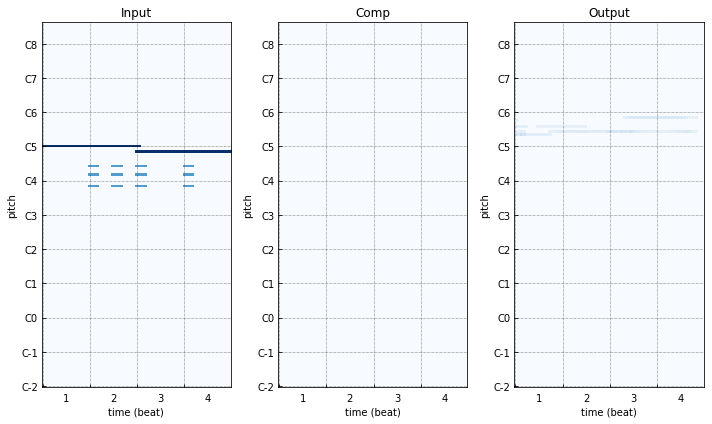

In [25]:
# Inspect a random input-output sample
# sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_comp = comp_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 10] = 0

print(sample_input.shape)
print(sample_comp.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Comp')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], sample_comp, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(sample_comp)
pianoroll_utils.playPianoroll(sample_output)
pianoroll_utils.playPianoroll(sample_input+sample_output)


# Autoencoder V2

`code given below`

### Details

Iterating on the faults of the previous model: 
1. Change from an `input->input` autoencoder to a `input->comp` de-noising autoencoder,
2. Reduce size of embedding layer by increasing number of conv/pooling layers.

```
Data: input->comp, input->input
Embedding shape: (None, 3, 2, 100) -> 600 elements
Epochs: 50
Batch size: 128
Final loss: [loss: 0.0322 - val_loss: 0.0334]
```

### Notes

#### Test \#1
`input->comp`

This test was an absolute disaster! The output produced _actually_ sounded like someone dropping a piano off a cliff (which is fun but not very useful for the purpose of this project).

Interesting things to note - the training and validation loss started at `loss: 0.0375 - val_loss: 0.0302`, then ended at `[loss: 0.0322 - val_loss: 0.0334]`, barely learning anything at all. The model seemed to be improving consistently at the beginning, reaching a loss of about `0.02` at the halfway point (25th epoch), but then started getting worse consistently. Why did this happen? I thought that GD should only ever improve the model (or in the case of BGD, deteriorate slightly but improve overall). Also, what I hear is clearly not only 2% error. Maybe need to re-evaluate the loss function.

One other thing about the model, is that perhaps it is too much to expect it to be able to predict the left and right accompaniments. Might be worth trying `input->full` instead of `input->comp`, and maybe think of a completely new way to structure the data...

Finally, the model itself was also changed significantly from the previous version. Maybe the drop in hidden layer dimension is too steep, or the embedding size is too small. Should test with basic `input->input` case first.

#### Test \#2
`input->input`

Hmm, interestingly this wasn't any better than the input->comp instance. Which implies that the model itself is broken. Onwards!

#### Follow-up

Applying a threshold-to-zero filter on notes with low velocity helped in removing the "dropped piano" noise, but the remaining output was consistently bad. It appears that the model is taking wild guesses with too many notes at low velocities (close to no notes remain after a velocity-50 threshold), even for the simplest `input-input` autoencoder task.

Comparing this to AEV1, we can conclude that the output thresholding is likely a good idea, and that the right network should indeed be able to reproduce a close decoding. The good performance of AEV1 and poor performance of AEV2 implies that the data is usable, the loss function is acceptable, and most likely the main problem is just finding the right autoencoder network. This should be the next priority - designing a network which produces a smaller embedding than AEV1 while maintaining output quality.

### Next steps
1. Investigate output (why doesn't the pianoroll plot look like a piano being thrown off a cliff?)
2. Investigate behaviour of the trainig/validation losses.
3. ~~Try using `input-input` and `input-full` to make sure the model can actually something useful.~~ 
4. Try a different autoencoder architecture.

In [6]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)

x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the data is already represented in the embedding

# DECODER
x = Conv2D(100, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(200, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 96, 1)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 16, 200)       54800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 16, 200)       800       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 16, 100)       180100    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 8, 100)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 8, 100)        90100     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 4, 100)         0         
__________

In [7]:
# Train model [INPUT->COMP]
autoencoder.fit(input_train, comp_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, comp_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2.h5'
autoencoder.save(MODEL_AUTOENCODER_V2_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V2_FILE

Train on 2924 samples, validate on 344 samples
Epoch 1/50
2924/2924 [==============================] - 21s 7ms/step - loss: 0.0375 - val_loss: 0.0302
Epoch 2/50
2924/2924 [==============================] - 15s 5ms/step - loss: 0.0273 - val_loss: 0.0265
Epoch 3/50
2924/2924 [==============================] - 15s 5ms/step - loss: 0.0250 - val_loss: 0.0252
Epoch 4/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0241 - val_loss: 0.0247
Epoch 5/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0242 - val_loss: 0.0255
Epoch 6/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0243 - val_loss: 0.0246
Epoch 7/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0236 - val_loss: 0.0241
Epoch 8/50
2924/2924 [==============================] - 15s 5ms/step - loss: 0.0233 - val_loss: 0.0242
Epoch 9/50
2924/2924 [==============================] - 14s 5ms/step - loss: 0.0239 - val_loss: 0.0255
Epoch 10/50
2924/2924 [===

In [8]:
# Train model [INPUT->INPUT]
autoencoder.fit(input_train, input_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2_input_input.h5'
autoencoder.save(MODEL_AUTOENCODER_V2_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V2_FILE

Train on 2922 samples, validate on 346 samples
Epoch 1/50
2922/2922 [==============================] - 21s 7ms/step - loss: 0.0529 - val_loss: 0.0385
Epoch 2/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0388 - val_loss: 0.0374
Epoch 3/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0372 - val_loss: 0.0365
Epoch 4/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0348 - val_loss: 0.0344
Epoch 5/50
2922/2922 [==============================] - 13s 5ms/step - loss: 0.0330 - val_loss: 0.0334
Epoch 6/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0366 - val_loss: 0.0395
Epoch 7/50
2922/2922 [==============================] - 13s 5ms/step - loss: 0.0338 - val_loss: 0.0324
Epoch 8/50
2922/2922 [==============================] - 15s 5ms/step - loss: 0.0366 - val_loss: 0.0428
Epoch 9/50
2922/2922 [==============================] - 14s 5ms/step - loss: 0.0361 - val_loss: 0.0367
Epoch 10/50
2922/2922 [===

In [5]:
MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2_input_input.h5'
autoencoder = load_model(MODEL_AUTOENCODER_V2_FILE)

In [6]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)

(96, 128)
(96, 128)


0

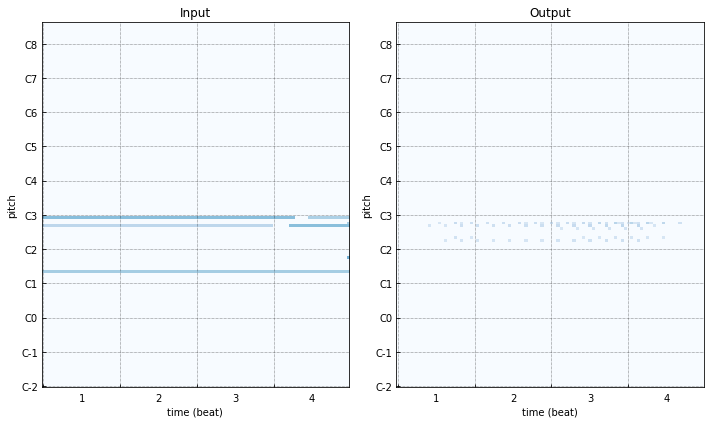

In [12]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
# sample_comp = comp_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 20] = 0

print(sample_input.shape)
# print(sample_comp.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
# ax[1].set_title('Target')
ax[1].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
# pypianoroll.plot_pianoroll(ax[1], sample_comp, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], sample_output, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_comp)
pianoroll_utils.playPianoroll(sample_output)


# Autoencoder V3

`code given below`

### Details

The focus of this model is to use a small enough embedding layer, such that we can do nearest-neighbour unit selection.

```
Data: input->input
Embedding shape: (None, 3, 2, 100) -> 600 elements
Epochs: 50
Batch size: 128
Final loss: 
```

We begin with a baseline embedding of 600 elements (by comparison, Bretan uses a 500-value embedding), loaded directly from AEV2 ([reference](https://github.com/keras-team/keras/issues/41) for loading encoder weights in Keras; [docs](https://keras.io/layers/about-keras-layers/) on Keras layers). 

### Notes

Pretty happy with this! Lots more to go, but I'm glad to have a working implementation of unit selection - it's quite a milestone to have something that successfully uses an encoder to get an embedding, which we can subsequently do nearest-neighbor selection from!

This is my first approach which produces non-piano-off-the-cliff results, which is encouraging. But then again, legible output is pretty much guaranteed by the unit selection method, so it's still to early to celebrate.

Interestingly, testing the system with training data does not give back the exact same input, but it seems to give a reasonably "close-sounding" match. Which is reasonable, given that our embedding dimensionality is so much smaller than the original. 

Using testing data, the corresponding kNN match is much less similar to the data, which is expected to some extent. There seems to be some sort of rhythmic or note-density similarities in the input->matched pair, but this may be my own confirmation bias. 

Most important thing to do now is to find a way to measure the "appropriateness" of the generated outputs, and then we can start to benchmark/quantify our results. :))

### Next steps
1. Try different embeddings
2. Quantify results

In [5]:
MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2_input_input.h5'
ae_V2 = load_model(MODEL_AUTOENCODER_V2_FILE)

In [6]:
# for layer in ae_V2.layers:
#     print layer, len(layer.get_weights())

In [7]:
# Recreate just the encoder portion of AEV2 
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)

x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_mat, encoded)
encoder.compile(optimizer='adam', loss='binary_crossentropy')

## Load up the weights trained with AEV2
for i, layer in enumerate(encoder.layers):
    encoder.layers[i].set_weights(ae_V2.layers[i].get_weights())


In [8]:
MODEL_FILE = './models/encoder_v2_input_input.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

Saved Keras model to ./models/encoder_v2_input_input.h5


In [9]:
del encoder
encoder = load_model(MODEL_FILE)

In [11]:
def getFlattenedEncodings(inputs, enc):
    """
    Given an input matrix of shape (M, 128, 96, 1) and a trained encoder model,
    run each M pianorolls through the encoder and return an (M, F) matrix 
    where F is the length of the FLATTENED embedding layer.
    """
    assert inputs.shape[1] == 128
    assert inputs.shape[2] == 96
    assert inputs.shape[3] == 1
    
    encodings = enc.predict(inputs)
    flat_encodings = encodings.reshape(encodings.shape[0], -1)
    return flat_encodings

# Build a dataset of embeddings of our input units
encoded_inputs = getFlattenedEncodings(input_train, encoder)
print(encoded_inputs.shape)

(3457, 600)


In [14]:
from sklearn.neighbors import NearestNeighbors
import sklearn.externals

# Training the nearest neighbors model
knn_model = NearestNeighbors(n_neighbors=1).fit(encoded_inputs)

# Save model along with the units used to learn the model
KNN_MODEL_FILENAME = "./models/unit_selector_knn.pkl"
sklearn.externals.joblib.dump((knn_model, input_train, comp_train), KNN_MODEL_FILENAME)

['./models/unit_selector_knn.pkl']

729 767


0

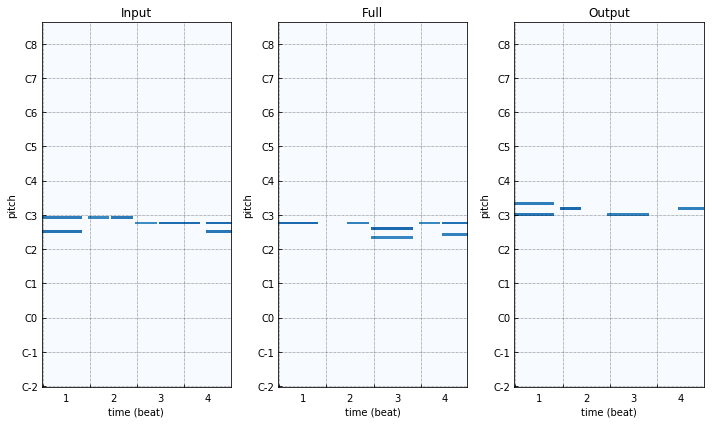

In [115]:
# Testing the model with training data!

# Choose a sample input to find the nearest neighbor of 
# (in this case, the 1nn should be itself, or a unit which is almost identical to itself)
sample_index = np.random.randint(len(input_train))
sample_input = input_train[sample_index].reshape(1, 128, 96, 1)
sample_encoding = getFlattenedEncodings(sample_input, encoder)
# Prediction
knn_index = knn_model.kneighbors(sample_encoding, return_distance = False)[0][0]
print sample_index, knn_index

sample_input = input_train[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
knn_input = input_train[knn_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
knn_comp = comp_train[knn_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Full')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], knn_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[2], knn_comp, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(knn_input)
pianoroll_utils.playPianoroll(knn_comp)

0

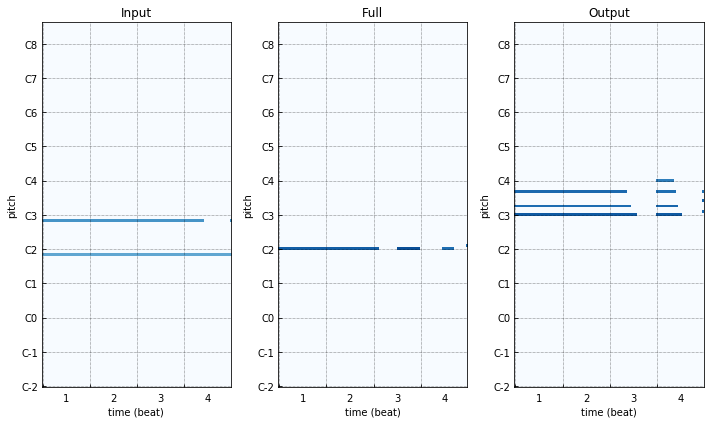

In [138]:
# Testing the model with test data!

# Inspect a random input-output sample
# Choose a test input to find the nearest neighbor of
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].reshape(1, 128, 96, 1)
sample_encoding = getFlattenedEncodings(sample_input, encoder)
# Prediction
knn_index = knn_model.kneighbors(sample_encoding, return_distance = False)[0][0]
sample_input = input_train[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
knn_input = input_train[knn_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
knn_comp = comp_train[knn_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Full')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], knn_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[2], knn_comp, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(knn_input)
pianoroll_utils.playPianoroll(knn_comp)


# Autoencoder V4

`code given below`

### Details

Trying to reduce the embedding size of AEV1 without losing all musicality (as happened in AEV2).

```
Data: input->input
Embedding shape: (None, 16, 12, 32) -> 6144 elements
Epochs: 100
Batch size: 32
Final loss: [loss: -0.0047 - val_loss: -0.0052]
```

### Notes

#### Attempt \#1

Adding more conv-pooling pairs (even just one more) to AEV1 had a devastating effect on the decoded output. The training/validation loss also seemed to stagnate at around 16% after just one or two iterations, so I quickly aborted the mission.

#### Attempt \#2

Tried to copy the model of AEV2, but removed one conv-pooling pair in hopes that the output would be better than AEV2. Not much difference.

#### Attempt \#3

**Here's where it gets so much better**: AEV2 with one less conv-pooling pair, and changed the loss function from binary crossentropy to _mean-squared error_, and the results are MAGNITUDES BETTER. (I mean, who's bright idea was it to use binary crossentropy for a pianoroll matrix anyway?) 

The output is acceptable (sounds mostly similar to the input except for some stray wrong notes or occasional dropped notes) even without any thresholding to zero. 

The best loss now is: `loss: 4.7768e-04 - val_loss: 8.2842e-04`. The logical next step will be to add back the conv-pooling pair and see what happens...

#### Attempt \#4

Recap: The model is exactly the same as AEV2, but with mean-squared error instead of binary crossentropy. This makes sense, and (more importantly?) it gives a good decoded output with an embedding size of just 600! 

The best loss now is: `loss: 0.0010 - val_loss: 0.0015` which is slightly poorer than the previous attempt, but this is expected given that we have shrunk the embedding size from 2400 to 600 (This is a good thing, but may not be necessary considering the tradeoff in reconstruction accuracy).

Importantly, we begin to get a sense of how the convolutional autoencoder starts to fail in this current architecture - the notes are treated simply as numbers - there is no category, no understanding of relationship between notes, which pairs go together, and whatnot. The autoencoder tries to numerically approximate the closest numerical reconstruction, but does not appear to have learnt any musical rules (this is my guess, given the seeming randomness of wrong note-attempts and note drops in the reconstruction).

As such, I expect that the model will do quite poorly in the next task: to learn a encoder-decoder mapping for `input->full`.

#### Attempt \#5

Here, for the task of `input->full`, we approach the limitations of our current approach. The reconstruction is actually not very bad - the output is doing well at replicating the input, but the 'accompaniment' it adds on to the input to make it more full, are more often than not, bad choices. Overall, the output sounds acceptable, and on occasion the accompaniment seems interesting and almost believable as the work of a particularly audacious composer. But alas, this is not enough.

The important thing to remember now, before running off to change from a convolutional autoencoder to a one-hot encoded RNN autoencoder, is that if we can successfully create a variational autoencoder, it may not be necessary at all to master the `input->full` or `input->comp` tasks (although I cannot deny how wonderful it would be to do so)! 

A variational autoencoder would give us the flexibility (via latent space arithmetic) to produce a sufficiently different output given an input, that it would no longer be considered a copy! So, so long as we can learn a musically correct latent space, we are in the gold.

### Next steps
1. Try putting this into a live demo context. :)
2. Start work on RNNs for next-unit prediction.
3. Consider changing the convolutional autoencoder architecture (though this should hardly be a priority for now).

In [58]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)

x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the data is already represented in the embedding

# DECODER
x = Conv2D(100, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(200, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [59]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 96, 1)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 16, 200)       54800     
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 16, 200)       800       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 24, 16, 100)       180100    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 12, 8, 100)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 12, 8, 100)        90100     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 4, 100)         0         
__________

In [60]:
# Train model model
autoencoder.fit(input_train, input_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v4.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

Train on 2908 samples, validate on 360 samples
Epoch 1/50
2908/2908 [==============================] - 16s 5ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 2/50
2908/2908 [==============================] - 14s 5ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 3/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 4/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 5/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 6/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 7/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 8/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/50
2908/2908 [===

In [66]:
# Train model model
autoencoder.fit(input_train, full_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, full_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v4_input_full.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

Train on 2908 samples, validate on 360 samples
Epoch 1/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 2/50
2908/2908 [==============================] - 13s 4ms/step - loss: 0.0058 - val_loss: 0.0066
Epoch 3/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0058 - val_loss: 0.0066
Epoch 4/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 5/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 6/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 7/50
2908/2908 [==============================] - 15s 5ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 8/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0052 - val_loss: 0.0059
Epoch 9/50
2908/2908 [==============================] - 13s 5ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 10/50
2908/2908 [===

In [5]:
MODEL_AUTOENCODER_FILE = './models/autoencoder_v4.h5'
autoencoder = load_model(MODEL_AUTOENCODER_FILE)

In [6]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)
print decoded_test.shape

(381, 128, 96, 1)


(96, 128)
(96, 128)
(96, 128)


0

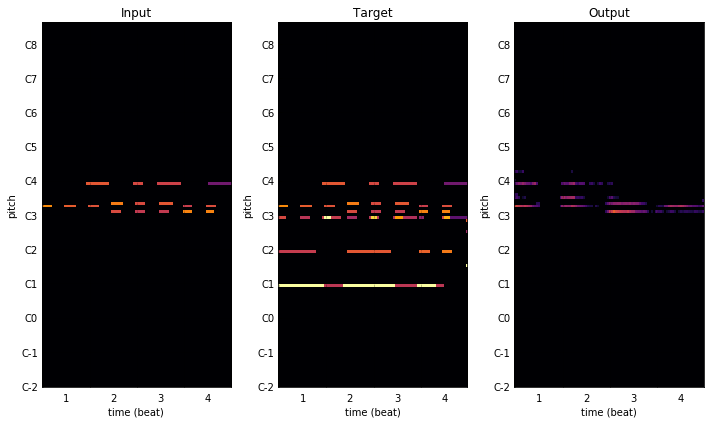

In [12]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_full = full_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 10] = 0

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_full, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_full)
pianoroll_utils.playPianoroll(sample_output)
